<a href="https://colab.research.google.com/github/YaninaK/predictive-maintenance/blob/main/notebooks/03_Baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Модель раннего обнаружения неисправностей промышленного оборудования
## Базовая модель

#### [Чтение и предварительная очистка данных](https://colab.research.google.com/drive/1UHlDhDV11MuN3C4U-KqpJP736KmudnyA?usp=sharing)

#### [Исследователский анализ данных](https://colab.research.google.com/drive/1E0JIOFlRn83lFcZxb2tp2mXKXB5N19t4?usp=sharing)

ОПИСАНИЕ ЗАДАЧИ

Разработать модель, определяющую возможность возникновения нештатной работы оборудования на временном горизонте не менее 3 часов до аварийного простоя.

[РЕСУРСЫ](https://drive.google.com/file/d/1jrbfHULbZuCnwJQwNllQUFlCGpR_lHDc/view?usp=sharing)

Наборы обезличенных данных из внутренних систем ПАО «Северсталь», содержащие:
* Перечень нештатных событий, приведших к остановке линии;
* Перечень нештатных событий, повлекших деградацию функций агрегатов;
* Перечень сигналов с датчиков, контроллеров.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/YaninaK/predictive-maintenance.git -q
!pip install -r predictive-maintenance/requirements_Colab.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 110.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 17.6 MB/s eta 0:00:00


In [3]:
%cd /content/predictive-maintenance

/content/predictive-maintenance


In [4]:
import sys
import os

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), "src", "predictive_maintenance"))

In [5]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf

import bambi as bmb
import arviz as az

from data.utilities import load_X,  load_y, get_y_summary
from features.etalon_periods import (
    select_etalon_periods, get_pca_components, generate_etalon_dataset,
)
from models.stoppages import get_M1_dataset
from data.anomalies import get_M3_dataset, generate_targets
from data.train_test_datasets import (
    combine_test_intervals, generate_test_dataset
)
from models.model_LSTM import get_model_LSTM

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
az.style.use("arviz-darkgrid")
SEED = 25

In [8]:
PATH = '/content/drive/MyDrive/ML_projects/02_Predictive_maintenance/'
FOLDER = "data/02_intermediate/"

## 1. Загрузка данных

In [9]:
messages = (
    pd.read_parquet(PATH + FOLDER + "messages_unified.parquet")
    .sort_values(by='ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ')
    .reset_index(drop=True)
)
print(f'messages.shape = {messages.shape}\n')
messages.head(2)

messages.shape = (981, 11)



,МАШИНА,ИМЯ_МАШИНЫ,ТЕХ_МЕСТО,НАЗВАНИЕ_ТЕХ_МЕСТА,ВИД_СООБЩЕНИЯ,ОПИСАНИЕ,ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ,ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ,ТЕКСТ_ГРУППЫ_КОДОВ,equipment,unified_name
0,AA2/006-006,ЭКСГАУСТЕР А/М №9,AA2/006-006-002-008,ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №9,M3,неисправен двигатель,2019-01-21 00:00:00,2019-02-25,None,9,ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №
1,CH-AGP-AG2/011-005,ЭКСГАУСТЕР А/М №9,CH-AGP-AG2/011-005-002,МАСЛОСТАНЦИЯ ЖИДКОЙ СМАЗКИ ЭКСГ. №9,M3,неисправен двигатель,2019-01-21 12:26:08,2019-02-25,None,9,МАСЛОСТАНЦИЯ ЖИДКОЙ СМАЗКИ ЭКСГ_ №


## 2. Модель LSTM

In [10]:
INPUT_SEQUENCE_LENGTH = 23

### 2.1. Генерация эталонного датасета.

In [11]:
etalon_periods = select_etalon_periods(messages, path=PATH)
etalon_periods.head(2)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,equipment
dt,,,,,,,,,,,,,,,,,
2019-01-16 13:00:00,1.563937,0.737879,0.645386,1.629186,3.351842,0.744417,119.448131,40.319054,33.33406,41.457225,39.738215,39.953993,44.636200,360.921722,360.921722,243.680833,4
2019-01-16 14:00:00,1.557182,0.743087,0.638876,1.568169,2.738252,0.730758,119.764306,40.165818,33.05043,41.361075,39.622131,39.864005,44.536324,357.194764,357.194764,244.688722,4


In [12]:
etalon_features, scaler_lstm, pca = get_pca_components(etalon_periods)
etalon_features.head(2)

,factor_0,factor_1,factor_2,Hotelling's T-squared,Q residuals,equipment
dt,,,,,,
2019-01-16 13:00:00,-0.988189,0.345751,-2.726740,3.577083,16.641088,4
2019-01-16 14:00:00,-0.861942,0.575467,-2.257506,2.532197,10.083960,4


In [13]:
etalon_dataset = generate_etalon_dataset(etalon_features)
etalon_dataset.shape

(7062, 50, 5)

In [14]:
ind = np.arange(etalon_dataset.shape[0])
np.random.shuffle(ind)
etalon_dataset = etalon_dataset[ind, :, :]

### 2.2. Обучение модели LSTM

In [15]:
t = INPUT_SEQUENCE_LENGTH
model_path = "models/LSTM_model.h5"
history_path = "models/model_LSTM_training_history.joblib"

In [16]:
regenerate = False
if regenerate:
  lstm_model = get_model_LSTM()
  n_epochs = 60
  batch_size = 64
  m = 1024
  reduce_lr = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 3e-2 * 0.95 ** epoch
  )
  history = lstm_model.fit(
      etalon_dataset[:-m, :t, :], etalon_dataset[:-m, t:, :],
      epochs=n_epochs,
      validation_data=(etalon_dataset[-m:, :t, :], etalon_dataset[-m:, t:, :]),
      batch_size=batch_size,
      verbose=1,
      callbacks=[reduce_lr],
      shuffle=True,
      workers=-1,
      use_multiprocessing=True
  )
  lstm_model.save(PATH + model_path)
  history = history.history
  joblib.dump(history, PATH + history_path)

else:
  lstm_model = tf.keras.models.load_model(PATH + model_path)
  history = joblib.load(PATH + history_path)

In [17]:
print(lstm_model.summary())

Model: "lstm_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, 23, 5)]              0         []                            
 )                                                                                                
                                                                                                  
 encoder_output1 (LSTM)      [(None, 23, 150),            93600     ['encoder_inputs[0][0]']      
                              (None, 150),                                                        
                              (None, 150)]                                                        
                                                                                                  
 encoder_output2 (LSTM)      [(None, 150),                180600    ['encoder_output1[0][

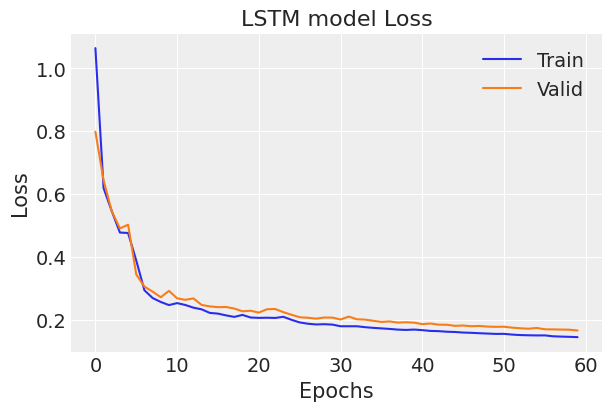

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title("LSTM model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

## 3. Байесовская модель

### 3.1. Подготовка эталонных данных для байесовской модели

In [19]:
pred_etalon = lstm_model.predict(etalon_dataset[:, :t, :])
pred_etalon.shape

221/221 [==============================] - 6s 5ms/step


(7062, 27, 5)

In [20]:
T2_Q_from_LSTM_etalon = pred_etalon[:, :, -2:].reshape(-1, 2)
T2_Q_from_LSTM_etalon = pd.DataFrame(T2_Q_from_LSTM_etalon, columns=['T2', 'Q'])
T2_Q_from_LSTM_etalon['good'] = 1

T2_Q_from_LSTM_etalon.tail(2)

,T2,Q,good
190672,1.717851,4.149052,1
190673,1.717983,4.149205,1


### 3.2. Обучение модели на эталонных данных

In [21]:
bayesian_model_path = "models/Bayesian_model_v3.h5netcdf"

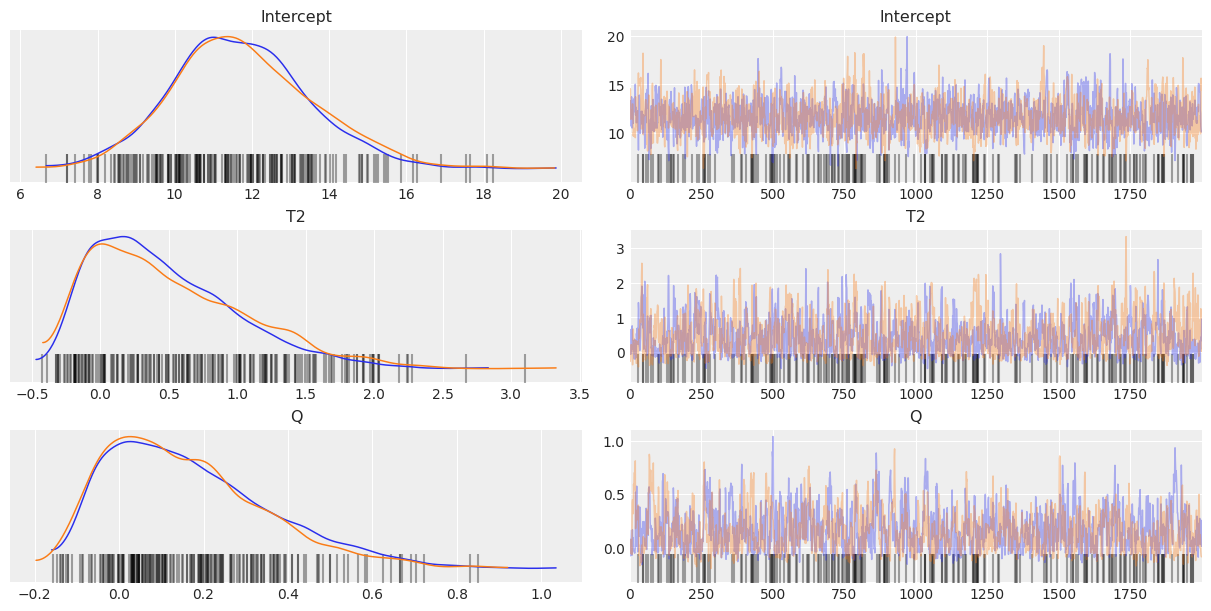

In [22]:
regenerate = False
if regenerate:
  bmb_model = bmb.Model(
    "good ~ T2 + Q", data=T2_Q_from_LSTM_etalon, family="bernoulli"
  )
  model_fitted = bmb_model.fit(
      draws=2000,
      target_accept=0.85,
      random_seed=SEED,
      idata_kwargs={"log_likelihood": True},
  )
  model_fitted.to_netcdf(PATH + bayesian_model_path)
else:
  model_fitted = az.InferenceData.from_netcdf(PATH + bayesian_model_path)

az.plot_trace(model_fitted, compact=False);

In [23]:
df = pd.DataFrame(columns=['Intercept', 'T2','Q'])
for i in range(2):
  intercept = model_fitted.posterior['Intercept'].to_numpy()[i]
  T2 = model_fitted.posterior['T2'].to_numpy()[i]
  Q = model_fitted.posterior['Q'].to_numpy()[i]

  df_ = pd.DataFrame(zip(intercept, T2, Q), columns=['Intercept', 'T2','Q'])
  df = pd.concat([df, df_], axis=0)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Intercept,4000.0,11.734078,1.797396,6.392747,10.524026,11.603146,12.858251,19.892180
T2,4000.0,0.481127,0.546622,-0.473097,0.047160,0.372549,0.818187,3.330774
Q,4000.0,0.164576,0.191092,-0.198077,0.014871,0.132381,0.277425,1.036800


### 3.3. Предсказание остановок.

#### LSTM input

In [24]:
INPUT_SEQUENCE_LENGTH

23

In [25]:
M1_dataset, M1_labels = get_M1_dataset(
    scaler_lstm,
    pca,
    messages,
    path=PATH
)
M1_dataset.shape, len(M1_labels)

((61, 23, 5), 61)

#### LSTM output

In [26]:
pred_stoppages = lstm_model.predict(M1_dataset)
pred_stoppages.shape

2/2 [==============================] - 0s 8ms/step


(61, 27, 5)

In [27]:
T2_Q_from_stoppages = pred_stoppages[:, :, -2:].reshape(-1, 2)
T2_Q_from_stoppages = pd.DataFrame(T2_Q_from_stoppages, columns=['T2', 'Q'])

T2_Q_from_stoppages.tail(2)

,T2,Q
1645,4.727775,69.477028
1646,4.737813,69.449219


#### Инференс байесовской модели горизонт - 27 часов.

In [28]:
bmb_model = bmb.Model(
    "good ~ T2 + Q", data=T2_Q_from_LSTM_etalon, family="bernoulli"
)
bmb_model.predict(model_fitted, data=T2_Q_from_stoppages)

In [29]:
good_posterior = az.extract(model_fitted)['good_mean']
y_pred = good_posterior.to_numpy().mean(axis=1)
y_pred.shape

(1647,)

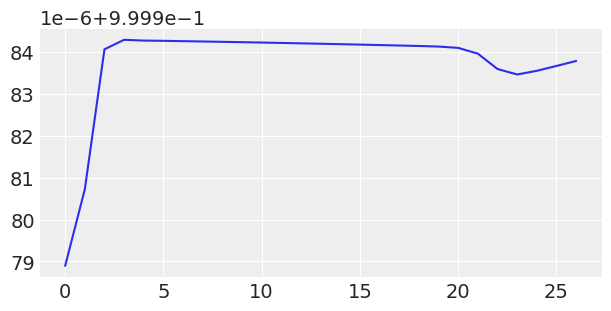

In [30]:
y = y_pred.reshape(-1, 27)

i = -1
plt.figure(figsize=(6, 3))
plt.plot(y[i, :]);

Если убрать 3 первые и 3 последние точки, то график приобретает ожидаемую форму:

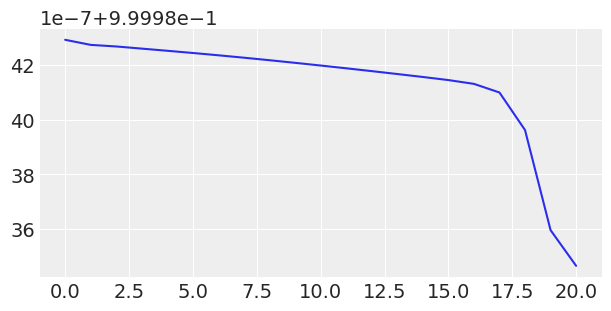

In [31]:
i = -1
plt.figure(figsize=(6, 3))
plt.plot(y[i, 3:-3]);

В таком случае, о неплановой остановке, которая произойдет через 27 часов, мы можем предупредить за сутки. И это происходит во всех 61 случаях:

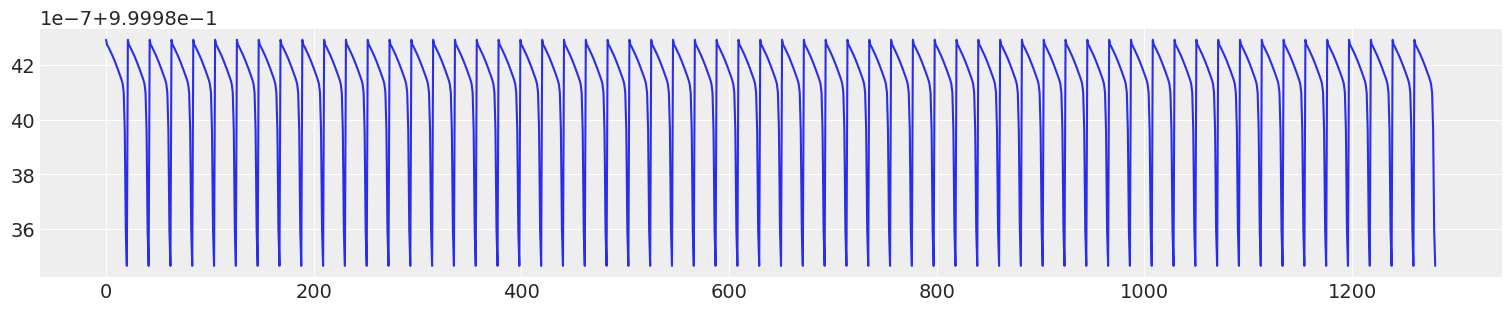

In [32]:
y_tranc = y[:, 3:-3].flatten()

plt.figure(figsize=(15, 3))
plt.plot(y_tranc);